# House Prices: Advanced Regression Techniques
## Goal: To predict the sales price for each house. 
## For each Id in the test set, you must predict the value of the SalePrice variable. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df_train=pd.read_csv('houseprices/train.csv')

In [2]:
# Looking into features and data types of those.
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## Feature selection (filter method by correlation)

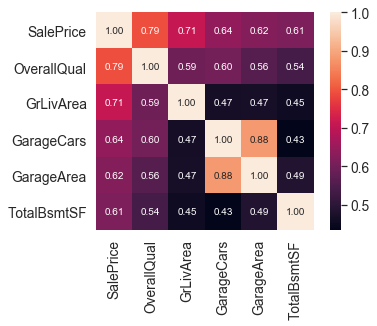

In [3]:
#saleprice correlation matrix
corrmat=df_train.corr()
k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

5 highest correlated features with Sale Price:<br><br>
'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea','TotalBsmtSF'<br>

OverallQual: Rates the overall material and finish of the house<br>
GarageCars: Size of garage in car capacity<br>
GarageArea: Size of garage in square feet<br>
GrLivArea: Above grade (ground) living area square feet<br>
TotalBsmtSF: Total square feet of basement area<br>

Garage area and Garage cars are highly correlated, and only one feature needs to be picked.
Since garage cars are more correlated with outcome variable, I decided to exclude garage area.

## Relationship with the outcome variable

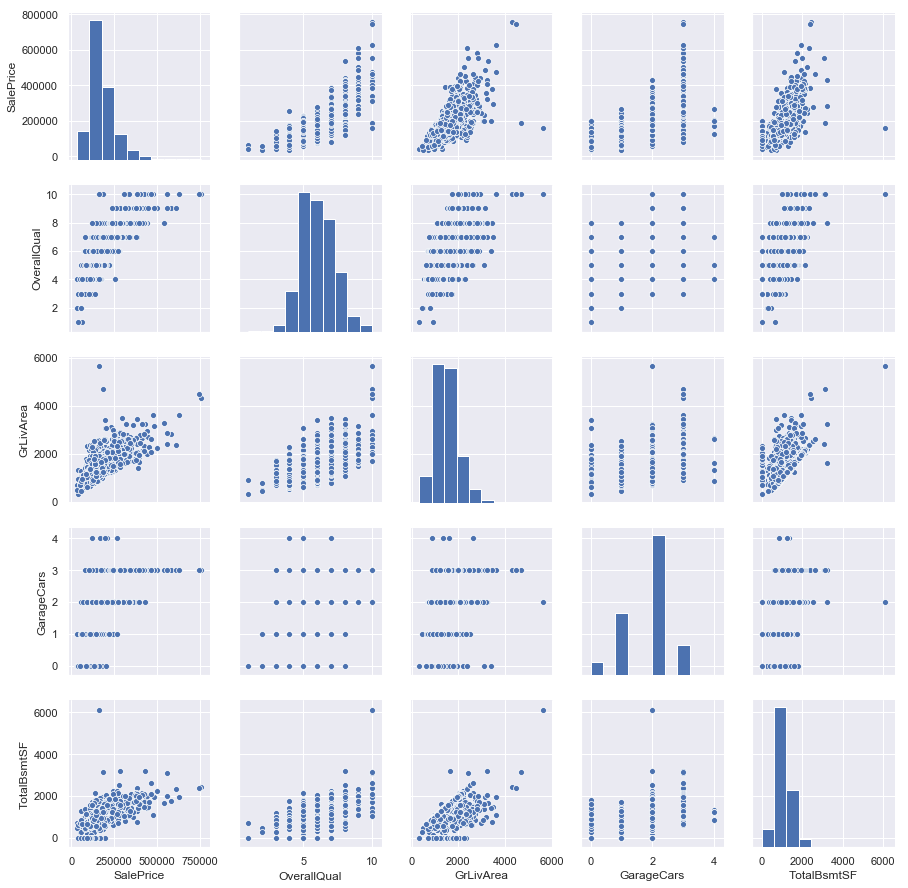

In [4]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

When looking at the first row, all features seem to have linear relationship with sales price, which is needed to perform linear regression.
By the way, we can see outliers in 'GrLivArea' and 'TotalBsmtSF'. How can we deal with these?

## Outliers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


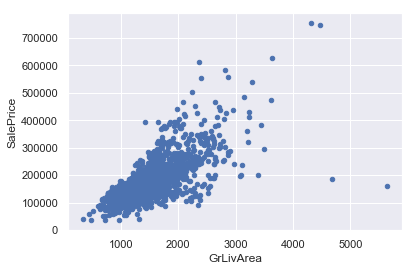

In [5]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice');

When looking into the scatter plot between GrLivArea and SalePrice, we can notice the two outliers which have very large living areas but with very low sale price. These two data points are deviated a lot from the regression line, and we can't find any systematic pattern or acceptable reasons to keep those outliers. Therefore, we decided to exclude those.  

In [6]:
# Excluding two outliers
df_train['GrLivArea'].sort_values(ascending=False)
df_train=df_train.drop(df_train[df_train['GrLivArea']==5642].index)
df_train=df_train.drop(df_train[df_train['GrLivArea']==4676].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


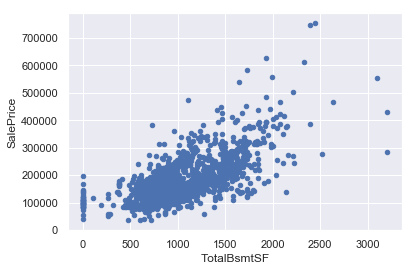

In [7]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice');

There are no outlier here. It turns out that the outlier in TotalBsmtSF was also removed in the outlier exclusion in GrLivArea right above.

## Missing data

In [8]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF']
df_train[cols].isnull().sum()

SalePrice      0
OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
dtype: int64

Fortunately, there is no missing data in the features.

## Linear Regression

In [9]:
from sklearn import linear_model
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

data=df_train[['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF']]
target=df_train['SalePrice']

# Instantiate our model.
regr = linear_model.LinearRegression()

# cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(regr,data,target, cv=10)

array([0.75851764, 0.82976482, 0.85352648, 0.82271523, 0.79405576,
       0.79481795, 0.76045484, 0.76220344, 0.78954028, 0.80400759])

In [26]:
df_test=pd.read_csv('houseprices/train.csv')

X_train=df_train[['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF']]
y_train=df_train['SalePrice']

X_test=df_test[['OverallQual', 'GrLivArea', 'GarageCars','TotalBsmtSF']]
y_test=df_test['SalePrice']

print('When training using train data and applying model to test data, the accuracy is \n',regr.fit(X_train, y_train).score(X_test, y_test))

When training using train data and applying model to test data, the accuracy is 
 0.7526599883112464


## KNN Regression

In [23]:
from sklearn import neighbors

print('Applying to test data\n')
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
print('Unweighted :',knn.fit(X_train, y_train).score(X_test, y_test))

knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
print('Weighted :',knn_w.fit(X_train, y_train).score(X_test, y_test))

from sklearn.model_selection import cross_val_score

print('\nCross Validation\n')
score = cross_val_score(knn, X_train, y_train, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X_train, y_train, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Applying to test data

Unweighted : 0.7168018375244614
Weighted : 0.9680378860528436

Cross Validation

Unweighted Accuracy: 0.68 (+/- 0.09)
Weighted Accuracy: 0.69 (+/- 0.11)


# Conclusion

- Although weighted KNN model using separate train and test data resulted in 96% accuracy, other results from KNN models above showed lower accuracy than that of linear model.
- However, we can't conclude linear model is always better than KNN model.
- Since the relationship between sales price and remaining features are linear, and data points are not much deviated from the regression line, this data property might be better suited to linear regression.